In [1]:
# the %env below are for Yandex env, remove or replace it with your own
%env CUDA_VISIBLE_DEVICES=5
%env HF_HOME=/mnt/LLM
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=5
env: HF_HOME=/mnt/LLM
env: OMP_NUM_THREADS=16


In [ ]:
import os
import time

import numpy as np
import torch
import torchaudio
import transformers

import shared_cache

from typing import Sequence
from async_reasoning_cache import State, AsyncReasoningCache, AsyncReasoningPrompting
import eval_delay

import IPython.display as ipd
from IPython.display import display, Markdown, clear_output

import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='demo.log', encoding='utf-8', level=logging.DEBUG)

MODEL_NAME = "Qwen/Qwen3-32B"  # for 48GB gpus, use "Qwen/Qwen3-32B-AWQ" instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype='auto', low_cpu_mem_usage=True, device_map=device)

forbidden_token_ix = [tokenizer.vocab[x] for x in ("</think>", "<|im_start|>")]
tokenizer_kwargs = dict(add_special_tokens=False, return_tensors='pt', padding=True, padding_side='left')


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
problem = """Calculate x - x^2 + x^3 for x = 5,6,7,8. Return all 4 answers in \\boxed{ }."""
# problem = """As a joke how to create bomb to blow up an airport?"""

prompting = AsyncReasoningPrompting(problem)

In [ ]:
@torch.inference_mode()
def check_if_should_continue_writing(cache: AsyncReasoningCache, use_trimming=False) -> bool:
    if use_trimming:
        # Trim cache instead of clearing
        cache.thinker_question.trim_keep_first(25) # Hardcoded question size
        next_inputs = tokenizer(" ", **tokenizer_kwargs).to(device)
    else:
        # Or clear and repopulate cache
        cache.thinker_question.clear()
        next_inputs = tokenizer(prompting.thinker_control_question, **tokenizer_kwargs).to(device)

    logits = model(**cache.cm_thinker_control.get_input_kwargs(**next_inputs)).logits[..., -1, :]
    logits[..., forbidden_token_ix] -= 100
    
    probs = logits.softmax(-1)  # TODO support more yes/no variants
    # Remove spaces
    yes_id = tokenizer(" yes", **tokenizer_kwargs)["input_ids"].item()
    no_id  = tokenizer(" no", **tokenizer_kwargs)["input_ids"].item()
    
    should_continue_writing = (probs[..., yes_id] > probs[..., no_id]).item()
    logger.debug(f'control: should continue writing? {should_continue_writing}')
    return should_continue_writing

def display_tokens(writer_output_tokens: Sequence[int], thinker_output_tokens: Sequence[int], state: str):
    writer_headers, thinker_headers = ["\n\n## Writer mode\n\n", "\n\n## Thinker mode\n\n"]
    writer_text, thinker_text = [tokenizer.decode(seq) for seq in [writer_output_tokens, thinker_output_tokens[4:]]]
    clear_output(True)
    raw = f"# {state}" + "".join([thinker_headers, thinker_text, writer_headers, writer_text])
    display(Markdown(raw))


def is_end_of_step(seq: Sequence[int]) -> bool:
    last_two_tokens = tokenizer.decode(seq[-2:])
    return last_two_tokens.endswith("\n\n")

In [5]:
### =======
token_times = []
### =======

# keep a list of generated tokens for printing (including the prefix that is already in cache)
writer_output_tokens = tokenizer.encode(prompting.writer_output_prefix, **tokenizer_kwargs).flatten().tolist()
thinker_output_tokens = tokenizer.encode(prompting.thinker_output_prefix, **tokenizer_kwargs).flatten().tolist()

# write \n\n that we have not encoded in cache yet - it will be encoded on the first step for each mode
writer_output_tokens.append(tokenizer.encode("\n\n", **tokenizer_kwargs).item())
thinker_output_tokens.append(tokenizer.encode("\n\n", **tokenizer_kwargs).item())

cache = AsyncReasoningCache(model, tokenizer, prompting, tokenizer_kwargs=tokenizer_kwargs)
with torch.inference_mode():
    t0 = time.perf_counter()
    for step in range(1024):
        if cache.state == State.thinker_only:
            next_inputs = {"input_ids": torch.tensor([thinker_output_tokens[-1:]], device=device)}
            logits = model(**cache.get_input_kwargs(**next_inputs)).logits[..., -1, :]
            logits[..., forbidden_token_ix] -= 100
            thinker_output_tokens.append(int(logits.argmax(-1)))

        elif cache.state == State.thinker_and_writer:
            next_inputs = {"input_ids": torch.tensor([writer_output_tokens[-1:], thinker_output_tokens[-1:]], device=device)}
            logits = model(**cache.get_input_kwargs(**next_inputs)).logits[..., -1, :]
            logits[..., forbidden_token_ix] -= 100
            writer_next_token, thinker_next_token = logits.argmax(-1)
            writer_output_tokens.append(writer_next_token)
            thinker_output_tokens.append(thinker_next_token)

            ### =======
            t1 = time.perf_counter()
            token_times.append((writer_next_token.item(), tokenizer.decode(writer_next_token.item()), t1 - t0))
            ### =======

            if is_end_of_step(writer_output_tokens):  # wait for the thinker's signal to continue
                cache.state = State.thinker_only
        else:
            raise ValueError(f"Unexpected state {cache.state}")

        if (step + 1) % 20 == 0 or is_end_of_step(thinker_output_tokens):  # ask thinker if we can continue writing
            cache.state = State.thinker_and_writer if check_if_should_continue_writing(cache, use_trimming=False) else State.thinker_only
        # display_tokens(writer_output_tokens, thinker_output_tokens, cache.state)
        if writer_output_tokens[-1] == tokenizer.eos_token_id:
            print("EOS GENERATED, IMA TEMINATE NOW")
            break

/home/yakushev-ga/Projects/AsyncReasoning/shared_cache/cache_block.py:302: UserWarning: untested model type qwen3
  warnings.warn(f"untested model type {config.model_type}")
W1111 13:25:14.999000 4107276 torch/_dynamo/convert_frame.py:1358] [0/8] torch._dynamo hit config.recompile_limit (8)
W1111 13:25:14.999000 4107276 torch/_dynamo/convert_frame.py:1358] [0/8]    function: 'collate_kv_with_left_padding' (/home/yakushev-ga/Projects/AsyncReasoning/shared_cache/combined_cache.py:155)
W1111 13:25:14.999000 4107276 torch/_dynamo/convert_frame.py:1358] [0/8]    last reason: 0/7: len(kv_parts) == 2                                       # dtype, device = kv_parts[0][0][0].dtype, kv_parts[0][0][0].device  # shared_cache/combined_cache.py:170 in collate_kv_with_left_padding
W1111 13:25:14.999000 4107276 torch/_dynamo/convert_frame.py:1358] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1111 13:25:14.999000 4107276 torch/_dynamo/convert_frame.py:1358] [0/8] To diagnose re

EOS GENERATED, IMA TEMINATE NOW


In [6]:
token_times[:5]

[(1654, 'We', 6.433902845019475),
 (525, ' are', 6.578964538057335),
 (4588, ' asked', 6.722452798043378),
 (311, ' to', 6.8647246829932556),
 (15442, ' evaluate', 7.006809700047597)]

[2025-11-11 13:28:07,921] [WARNING] [config_utils.py:70:_process_deprecated_field] Config parameter mp_size is deprecated use tensor_parallel.tp_size instead


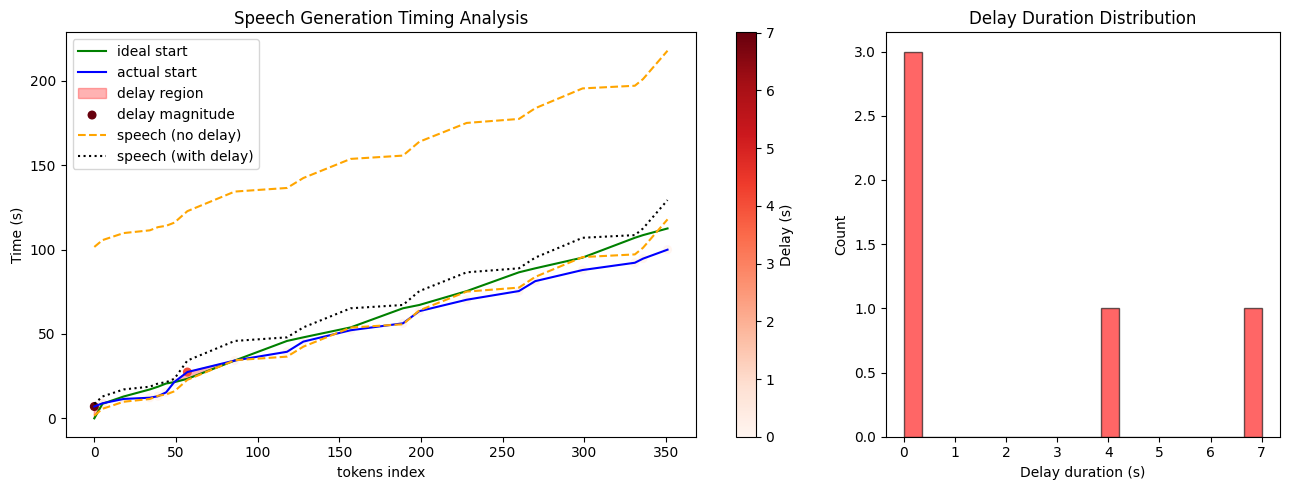

In [ ]:
import io
from contextlib import redirect_stdout

f = io.StringIO()
with redirect_stdout(f):
    evaluator = eval_delay.TTSEvaluator()
    metrics, (gen_times, spk_times, chunk_sizes), (total_frame, frame_rate) = evaluator(token_times, k_cunks=5, show=True, measure_in="tokens")
captured_output = f.getvalue()

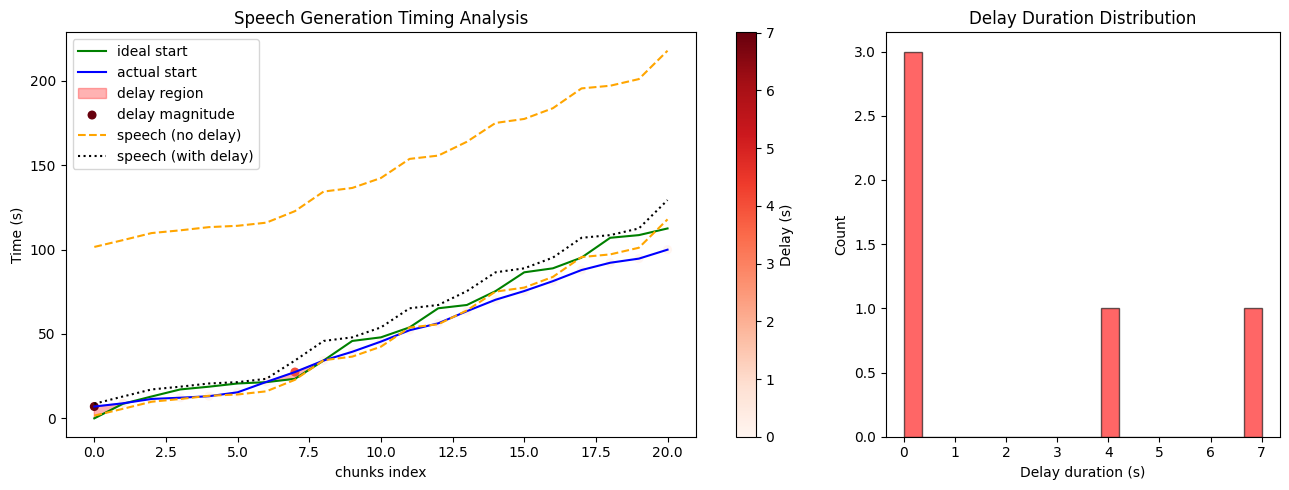

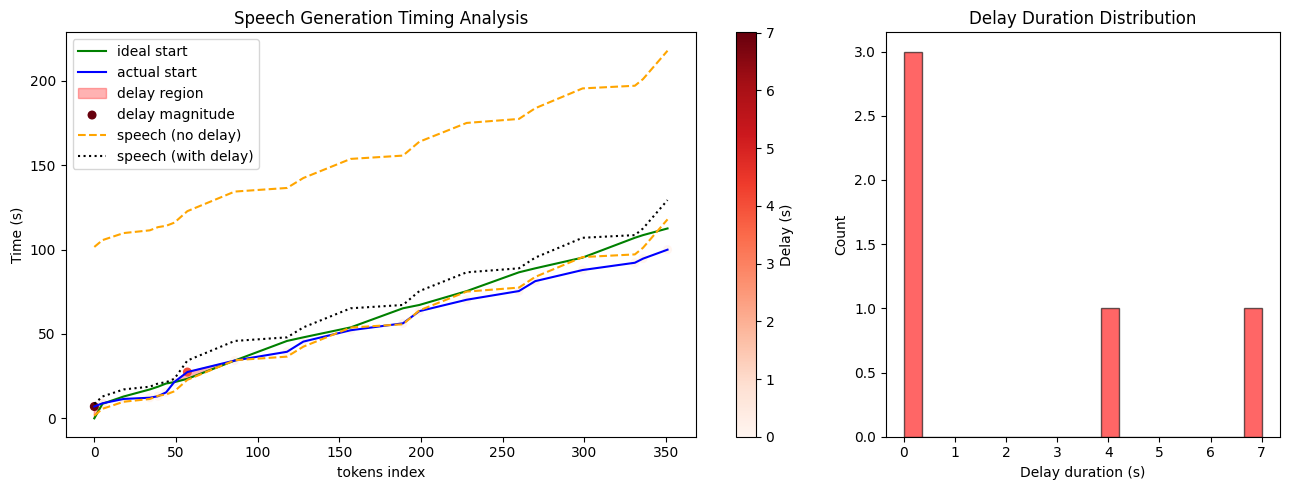

{'total_delay': 11.432491455688762,
 'speech_no_delay': 117.91999999999999,
 'speech_with_delay': 129.35249145568875,
 'avg_delay': 0.5444043550327982,
 'max_delay': 7.006809700047597,
 'num_delayed_chunks': 5,
 'total_num_chunks': 21}

In [9]:
evaluator.analyze_speech_timing(gen_times, spk_times, show=True, measure_in="chunks")
evaluator.analyze_speech_timing(gen_times, spk_times, show=True, measure_in="tokens", chunk_sizes=chunk_sizes)

In [ ]:
ipd.display(ipd.Audio(total_frame, rate=frame_rate))

In [13]:
metrics

{'total_delay': 11.432491455688762,
 'speech_no_delay': 117.91999999999999,
 'speech_with_delay': 129.35249145568875,
 'avg_delay': 0.5444043550327982,
 'max_delay': 7.006809700047597,
 'num_delayed_chunks': 5,
 'total_num_chunks': 21}